In [1]:
import datetime
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
%matplotlib inline

#### Read data

In [2]:
all_data = pd.read_csv('data/sap_00_18.csv')
all_data['Date'] = pd.to_datetime(all_data['Date'])
all_data.set_index(['Date'], inplace=True)

or

In [5]:
#start = datetime.datetime(2000, 1, 1)
#end = datetime.datetime(2018, 12, 31)
#all_data_sap = data.DataReader('^GSPC', 'yahoo', start, end)
#all_data_sap.head()

In [3]:
all_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [4]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4778 entries, 2000-01-03 to 2018-12-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4778 non-null   float64
 1   High       4778 non-null   float64
 2   Low        4778 non-null   float64
 3   Close      4778 non-null   float64
 4   Adj Close  4778 non-null   float64
 5   Volume     4778 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 261.3 KB


#### Visualize volume

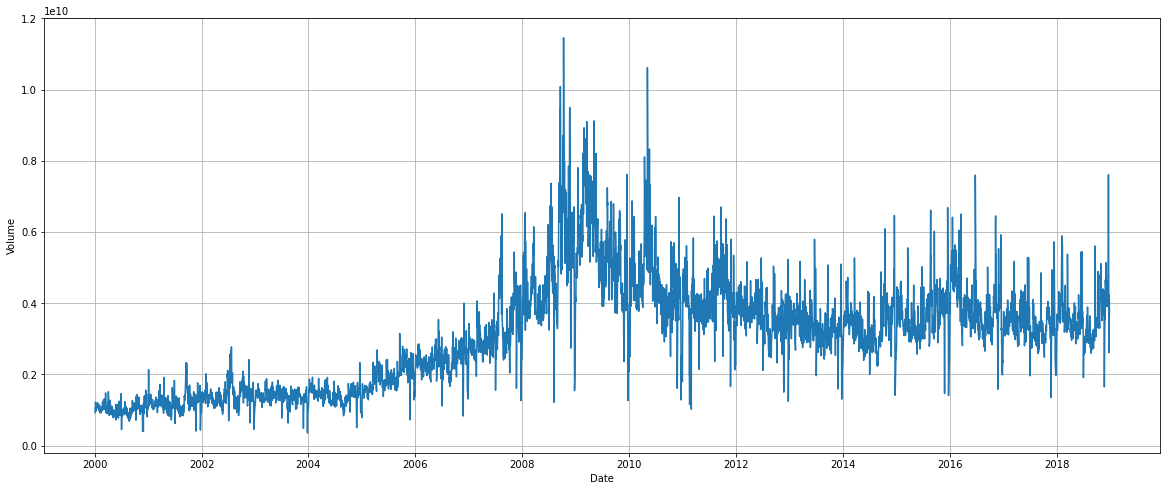

In [5]:
plt.figure(figsize=(20,8))
plt.plot('Date', 'Volume',data=all_data)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid()

#### Visualize prices 

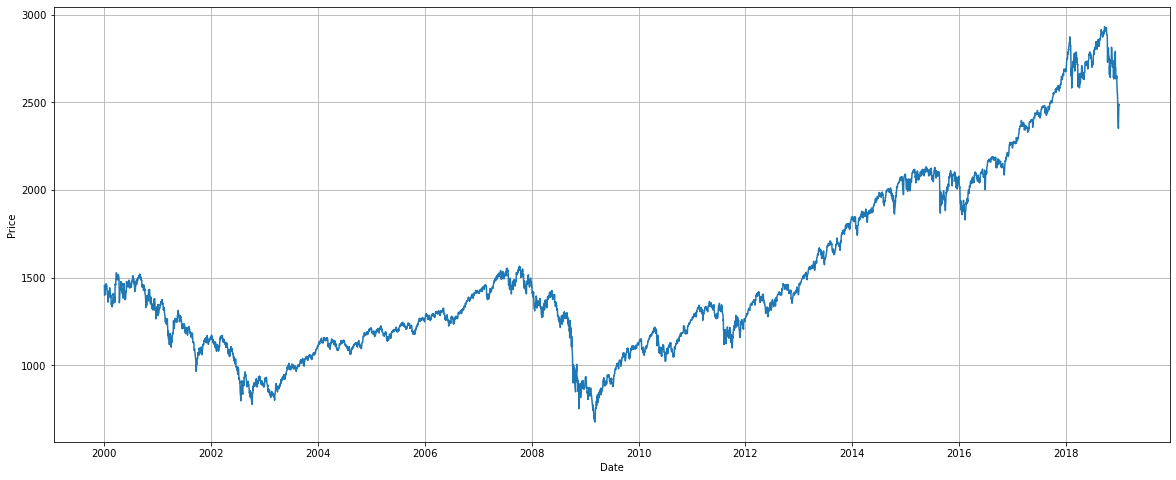

In [6]:
plt.figure(figsize=(20,8))
close_d, = plt.plot('Date', 'Close',data=all_data, label='Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()

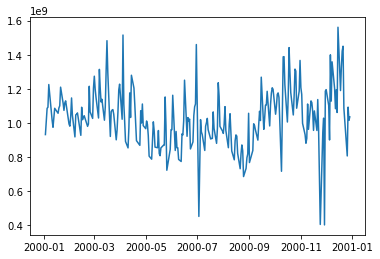

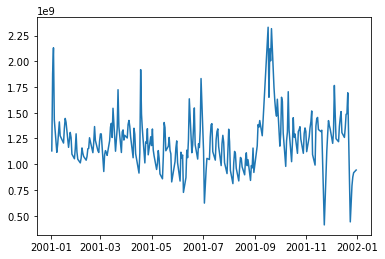

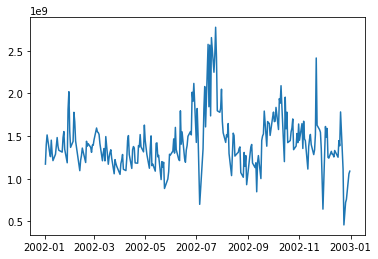

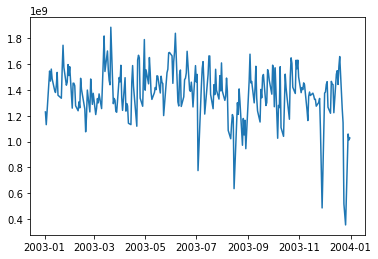

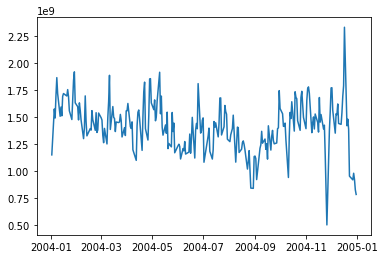

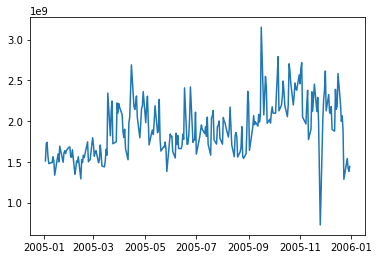

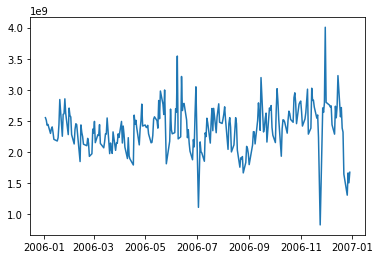

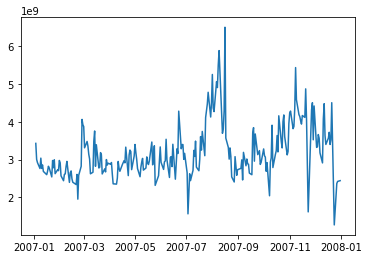

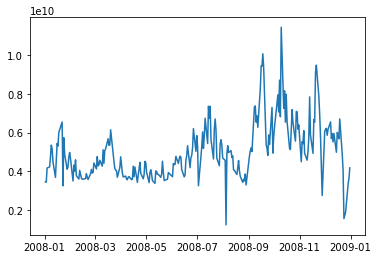

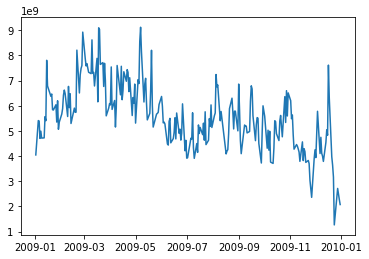

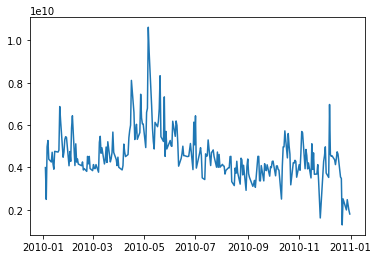

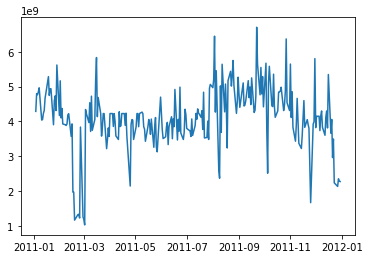

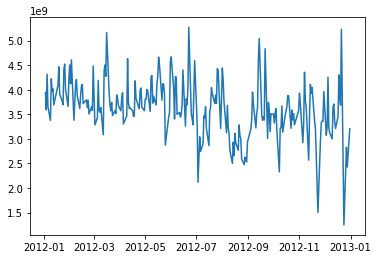

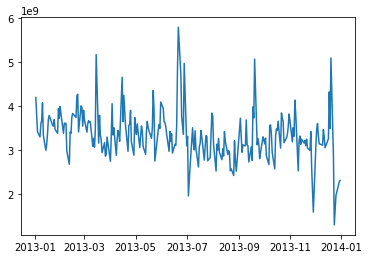

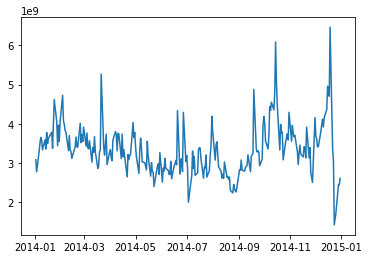

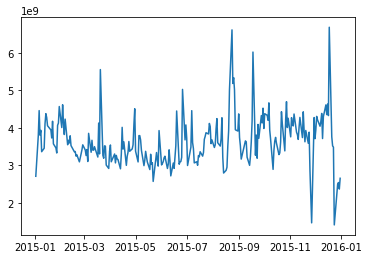

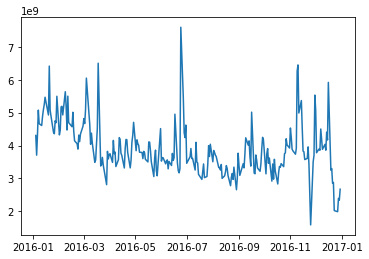

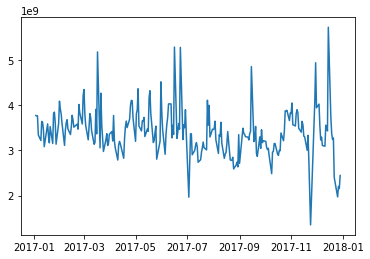

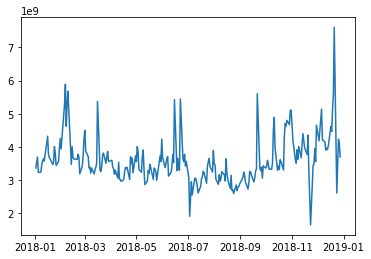

In [35]:
# Show volumes year by year
years = all_data.index.year.unique()

for i, year in enumerate(years):
    fig, ax = plt.subplots()
    ax.plot(all_data[f"{year}"]["Volume"], label='f"{year}"')

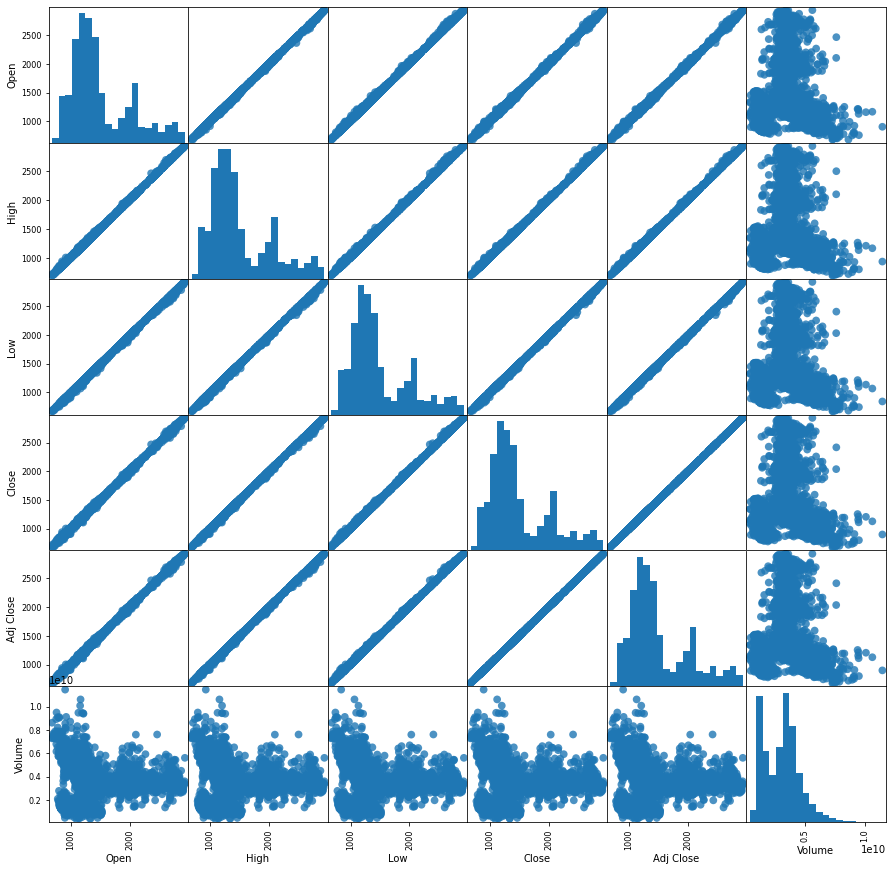

In [99]:
# Check for some noticable correlation of Volume on prices
grr = pd.plotting.scatter_matrix(all_data, figsize=(15, 15), marker='o', hist_kwds={'bins': 20}, s=60, alpha=.8)

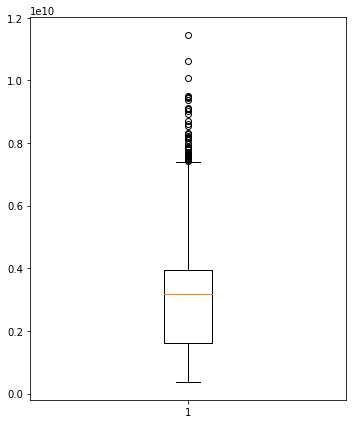

In [6]:
# Check outliers in the volume data
plt.figure(figsize=(5,6))
plt.boxplot(all_data['Volume'])
plt.tight_layout()

### Split the data into train/test sets

In [7]:
# split the data to train and test
train_data, test_data = all_data[:"2016"], all_data["2017":]

#### Basic Time Series analysis

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

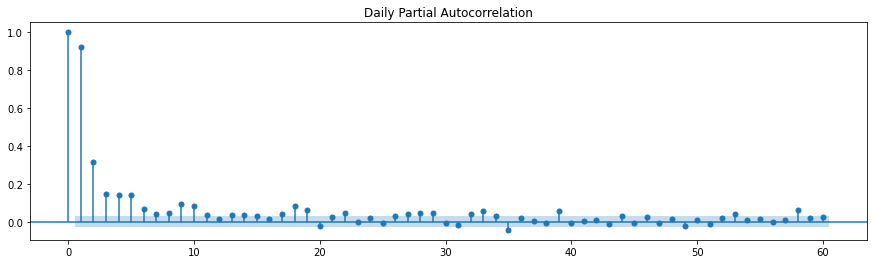

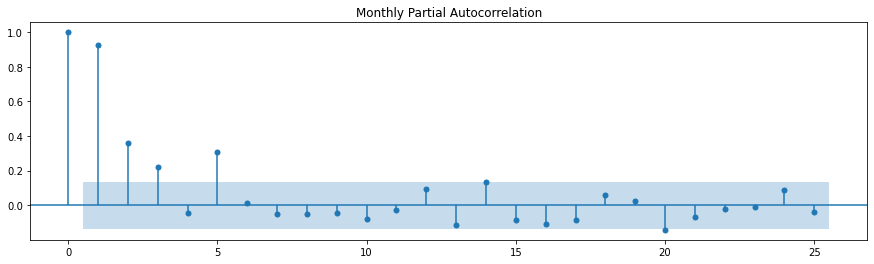

In [9]:
# Partial autocorrelations
fig, ax1 = plt.subplots(figsize=(15, 4))
fig, ax2 = plt.subplots(figsize=(15, 4))
daily_autocorr = plot_pacf(train_data['Volume'], lags=60, title='Daily Partial Autocorrelation', ax=ax1)
monthly_autocorr = plot_pacf(train_data['Volume'].resample('M').sum(), lags=25, title='Monthly Partial Autocorrelation', ax=ax2)

We can observe strong influence of the previous 5 days (business week) on today's volume and that, in general, data older 20 days (business month) has low impact on the today's volume. Also, volume in current month is correlated with the volume in previous 5 months.

### Seasonal decomposition

Text(0.5, 0.98, 'Multiplicative Decompose')

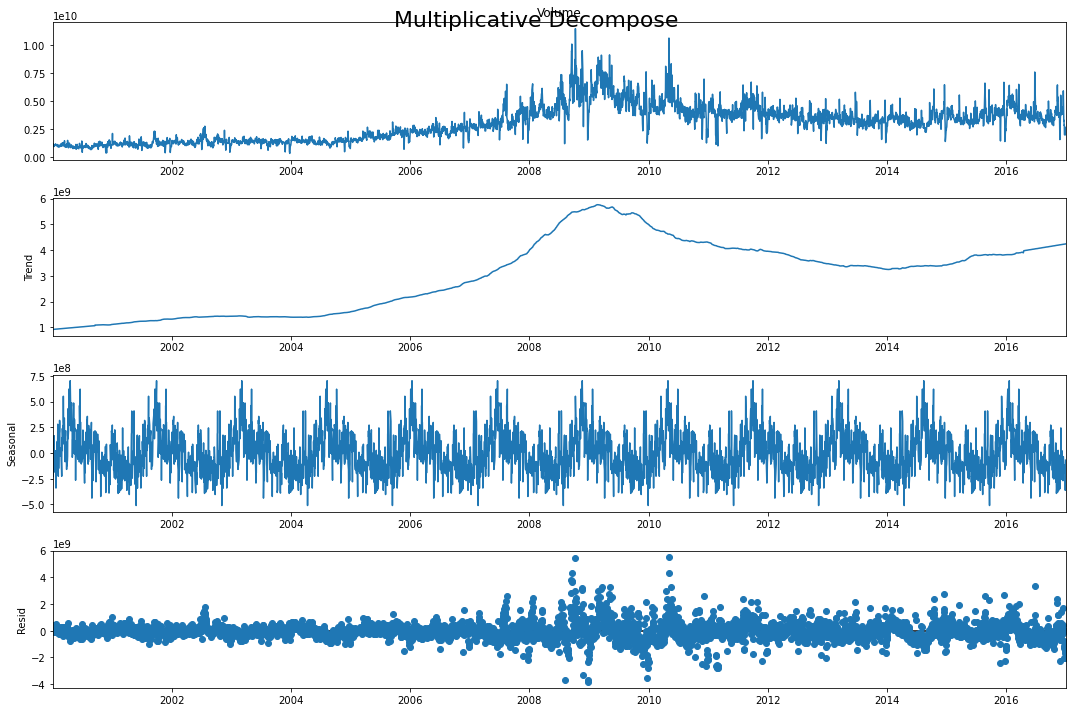

In [175]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative Decomposition (not very different from additive decomposition)
result_mul = seasonal_decompose(train_data['Volume'], model='additive', extrapolate_trend='freq', period=360)
plt.rcParams.update({'figure.figsize': (15,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)

### Stationarity

c:\programs\python377\venv\sap_predict\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


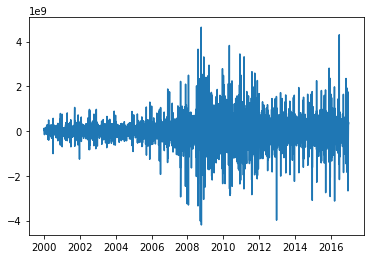

In [4]:
train_data['Volume_diff_1'] = train_data['Volume'] - train_data['Volume'].shift(1)
plt.plot(train_data['Volume_diff_1'].dropna())

In [155]:
# Augmented Dickey Fuller test for testing stationarity
from statsmodels.tsa.stattools import adfuller

result = adfuller(train_data['Volume_diff_1'].dropna(), autolag='AIC')
print(f'p-value: {result[1]}')

p-value: 3.633010652321793e-30


p-value < 0.05, thus the differenced searies should be stationary

#### Find best ARMA params

In [13]:
import statsmodels.api as sm
resDiff = sm.tsa.arma_order_select_ic(train_data['Volume_diff_1'].dropna().values, max_ar=7, max_ma=7, ic='aic', trend='nc')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')  # (4,4)

c:\programs\python377\venv\sap_predict\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
c:\programs\python377\venv\sap_predict\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
c:\programs\python377\venv\sap_predict\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\programs\python377\venv\sap_predict\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\programs\python377\venv\sap_predict\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(

ARMA(p,q) = (4, 4) is the best.


c:\programs\python377\venv\sap_predict\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## Historical events

In [75]:
all_reports = pd.read_csv('data/reports_all.csv')
all_reports['Start'] = pd.to_datetime(all_reports['Start'])
all_reports.head()

,Start,Name,Impact,Currency
0,2000-01-01 00:01:00,NaN,NONE,NZD
1,2000-02-02 00:00:00,RBA Interest Rate Decision,HIGH,AUD
2,2000-02-03 00:00:00,BoC Interest Rate Decision,HIGH,CAD
3,2000-02-04 00:00:00,ECB Interest Rate Decision,HIGH,EUR
4,2000-03-17 00:00:00,ECB Interest Rate Decision,HIGH,EUR


In [76]:
# How many impact values are there
all_reports.groupby('Impact').nunique()

,Start,Name,Currency
Impact,,,
HIGH,4818,300,9
LOW,22276,573,9
MEDIUM,17320,588,9
NONE,1219,298,9


In [77]:
impact_to_num = {'NONE': 0, 'LOW': 1, 'MEDIUM': 2, 'HIGH': 3}
all_reports['Impact'].replace(impact_to_num, inplace=True)

#### Prepare dataframe with aggregated report impacts

In [80]:
all_reports['Start'] = all_reports['Start'].dt.floor('d')  # round to days
row_list = []
for day in all_reports['Start'].unique():
    reports_in_day = all_reports.loc[all_reports['Start'] == day]
    max_impact = reports_in_day['Impact'].max()   # take the maximal impacts of that day
    max_impact_countries = reports_in_day[reports_in_day['Impact'] == max_impact]['Currency'].to_list()
    max_impact_events =  reports_in_day[reports_in_day['Impact'] == max_impact]['Name'].to_list()
    row = {'Start': day, 'Impact': max_impact, 'Name': max_impact_events,'Currency': max_impact_countries}
    row_list.append(row)

reports_agg = pd.DataFrame(row_list)

In [85]:
reports_agg.set_index('Start')
reports_agg.head()

,Start,Impact,Name,Currency
0,2000-01-01,0,[nan],[NZD]
1,2000-02-02,3,[RBA Interest Rate Decision],[AUD]
2,2000-02-03,3,[BoC Interest Rate Decision],[CAD]
3,2000-02-04,3,[ECB Interest Rate Decision],[EUR]
4,2000-03-17,3,[ECB Interest Rate Decision],[EUR]


#### Merge reports with data

In [83]:
all_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [97]:
joined = all_data.join(reports_agg.set_index('Start'), how='left')
joined['Impact'].fillna(0, inplace=True)
joined.fillna('', inplace=True)
joined.head()

,Open,High,Low,Close,Adj Close,Volume,Impact,Name,Currency
Date,,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,0.0,,
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,0.0,,
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,0.0,,
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,0.0,,
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,0.0,,


In [98]:
joined.to_csv('data/data_and_reports.csv')